# Machine Learning - Assignment 4

We continue Andrew Ng's course with Neural Networks Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.optimize as op
from scipy.io import loadmat

## Problem 1: Neural Networks

### Problem 1.1: Visualizing the Data

First, we load the data and look at the shapes and count values. Small exploratory data analysis.

In [2]:
data = loadmat('./data/ex4data1.mat')
X, y = data["X"], data["y"].ravel()

In [3]:
print(X.shape)

(5000, 400)


In [4]:
print(np.unique(y))
print(np.bincount(y)[1:])

[ 1  2  3  4  5  6  7  8  9 10]
[500 500 500 500 500 500 500 500 500 500]


We can see the data is pretty much the same (in format) as the data from excercise 3 (last post). So we know we can use the same code to plot the randomn 100 numbers below.

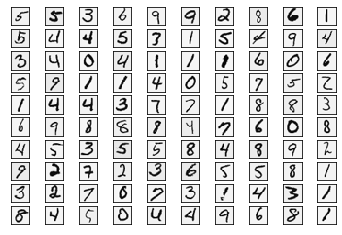

In [5]:
plt.figure()
rng = np.random.RandomState(0)
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(X[rng.randint(X.shape[0])].reshape((20, 20)).T,
               cmap=plt.cm.binary, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

### Problem 1.2: Model Representation

Load weight data 

In [6]:
w = loadmat('./data/ex4weights.mat')
theta1, theta2 = w["Theta1"], w["Theta2"]

In [7]:
print(theta1.shape)
print (theta2.shape)

(25, 401)
(10, 26)


We can see it is a simple 1 hidden layer neural network model. 

### Problem 1.3: Feedforwarding and cost function

Now we will implement the cost function and gradient for the neural network. $$J(\theta) = \frac{1}{m} \sum_{i=1}^m{\sum_{k=1}^K{
    [-y^{(i)}_k \log{((h_{\theta}}(x^{(i)}))_k) -
    (1 - y^{(i)}_k) \log{(1 - (h_{\theta}}(x^{(i)}))_k)]}} +
    \frac{\lambda}{2m}[\sum_{j=1}^{25}{\sum_{k=1}^{400}{(\theta_{j,k}^{(1)})^2}} +
    \sum_{j=1}^{10}{\sum_{k=1}^{25}{(\theta_{j,k}^{(2)})^2}}]$$

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lam):
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)]
    Theta1 = Theta1.reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):]
    Theta2 = Theta2.reshape((num_labels, hidden_layer_size + 1))

    X_train = np.hstack((np.ones((X.shape[0], 1)), X))
    A2 = sigmoid(np.dot(X_train, Theta1.T))
    A2 = np.hstack((np.ones((A2.shape[0], 1)), A2))
    A3 = sigmoid(np.dot(A2, Theta2.T))
    y_train = np.zeros((X.shape[0], num_labels))
    y_train[np.arange(X.shape[0]), y - 1] = 1
    J = -np.multiply(y_train, np.log(A3)) - np.multiply(1 - y_train, np.log(1 - A3))
    J = np.sum(J) / X.shape[0]

    reg = np.sum(np.power(Theta1[:, 1:], 2)) + np.sum(np.power(Theta2[:, 1:], 2))
    J += (reg * lam) / (2 * X.shape[0])

    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    delta3 = A3 - y_train
    delta2 = np.multiply(np.dot(delta3, Theta2), np.multiply(A2, 1 - A2))
    for i in range(X.shape[0]):
        Theta1_grad += np.dot(delta2[i, 1:][:, np.newaxis], np.atleast_2d(X_train[i]))
        Theta2_grad += np.dot(delta3[i][:, np.newaxis], np.atleast_2d(A2[i]))
    Theta1_grad /= X.shape[0]
    Theta2_grad /= X.shape[0]

    Theta1_grad[:, 1:] += lam * Theta1[:, 1:] / X.shape[0]
    Theta2_grad[:, 1:] += lam * Theta2[:, 1:] / X.shape[0]
    grad = np.hstack((Theta1_grad.ravel(), Theta2_grad.ravel()))
    return J, grad

Now, after setting our cost function, we can get J and grad

In [10]:
input_layer_size  = X.shape[1] #400
hidden_layer_size = theta1.shape[0] #25
num_labels = len(np.unique(y)) #10
nn_params = np.hstack((theta1.ravel(), theta2.ravel()))
lam = 0
J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lam)
print(J)

0.2876291651613189


If we use lambda = 1

In [11]:
J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, 1)
print(J)

0.38376985909092365


## Problem 2: Backpropagation

### Problem 2.1: Sigmoid Gradient

First, we setup sigmoid gradient function

In [12]:
def sigmoidGradient(z):
    return sigmoid(z)*(1-sigmoid(z))

In [13]:
sigmoidGradient(0)

0.25

### Problem 2.2: Random Init

Now, use random initializer to randomize initial theta values

In [14]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12
    rng = np.random.RandomState(0)
    W = rng.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

In [15]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.hstack((initial_Theta1.ravel(), initial_Theta2.ravel()))

### Problem 2.3: Backpropagation

In the previous function nnCostFunction we already included backpropagation and regularization. Code is just being split into two as always so scipy optimize can read effictifly each output

In [16]:
def cost(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lam):
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)]
    Theta1 = Theta1.reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):]
    Theta2 = Theta2.reshape((num_labels, hidden_layer_size + 1))

    X_train = np.hstack((np.ones((X.shape[0], 1)), X))
    A2 = sigmoid(np.dot(X_train, Theta1.T))
    A2 = np.hstack((np.ones((A2.shape[0], 1)), A2))
    A3 = sigmoid(np.dot(A2, Theta2.T))
    y_train = np.zeros((X.shape[0], num_labels))
    y_train[np.arange(X.shape[0]), y - 1] = 1
    
    J = -np.multiply(y_train, np.log(A3)) - np.multiply(1 - y_train, np.log(1 - A3))
    J = np.sum(J) / X.shape[0]
    reg = np.sum(np.power(Theta1[:, 1:], 2)) + np.sum(np.power(Theta2[:, 1:], 2))
    J += (reg * lam) / (2 * X.shape[0])
    return J

def gradient(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lam):
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)]
    Theta1 = Theta1.reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):]
    Theta2 = Theta2.reshape((num_labels, hidden_layer_size + 1))

    X_train = np.hstack((np.ones((X.shape[0], 1)), X))
    A2 = sigmoid(np.dot(X_train, Theta1.T))
    A2 = np.hstack((np.ones((A2.shape[0], 1)), A2))
    A3 = sigmoid(np.dot(A2, Theta2.T))
    y_train = np.zeros((X.shape[0], num_labels))
    y_train[np.arange(X.shape[0]), y - 1] = 1
    
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    delta3 = A3 - y_train
    delta2 = np.multiply(np.dot(delta3, Theta2), np.multiply(A2, 1 - A2))
    for i in range(X.shape[0]):
        Theta1_grad += np.dot(delta2[i, 1:][:, np.newaxis], np.atleast_2d(X_train[i]))
        Theta2_grad += np.dot(delta3[i][:, np.newaxis], np.atleast_2d(A2[i]))
    Theta1_grad /= X.shape[0]
    Theta2_grad /= X.shape[0]

    Theta1_grad[:, 1:] += lam * Theta1[:, 1:] / X.shape[0]
    Theta2_grad[:, 1:] += lam * Theta2[:, 1:] / X.shape[0]
    grad = np.hstack((Theta1_grad.ravel(), Theta2_grad.ravel()))
    return grad

### Problem 2.4: Gradient Checking

Gradient checking is a way to check our gradient is actually converging to help minimize the cost function. 

In [20]:
def checkNNGradients(lam):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
    rng = np.random.RandomState(0)
    X = rng.rand(m, input_layer_size)
    y = rng.randint(num_labels, size=m)
    nn_params = np.hstack((initial_Theta1.ravel(), initial_Theta2.ravel()))
    grad = gradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lam)
    num_grad = np.zeros(len(grad))
    e = 1e-4
    for i in range(len(grad)):
        nn_params1 = nn_params.copy()
        nn_params1[i] += e
        cost1 = cost(nn_params1, input_layer_size, hidden_layer_size, num_labels, X, y, lam)
        nn_params2 = nn_params.copy()
        nn_params2[i] -= e
        cost2 = cost(nn_params2, input_layer_size, hidden_layer_size, num_labels, X, y, lam)
        num_grad[i] = (cost1 - cost2) / (2 * e)
    print(grad[:5])
    print(num_grad[:5])
    assert np.linalg.norm(grad - num_grad) / np.linalg.norm(grad + num_grad) < 1e-9

In [34]:
checkNNGradients(0)

[0.0114253  0.00554851 0.00865516 0.0062458  0.00759429]
[0.0114253  0.00554851 0.00865516 0.0062458  0.00759429]


### Problem 2.5: Regularized NN

In [26]:
lam = 3
checkNNGradients(lam)
#Also output the costFunction debugging value 
#This value should be about 0.576051
debug_J  = cost(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lam)
print('Cost at (fixed) debugging parameters (w/ lambda = 3):', debug_J)

[0.0114253  0.03653578 0.02345308 0.01270898 0.00759429]
[0.0114253  0.03653578 0.02345308 0.01270898 0.00759429]
Cost at (fixed) debugging parameters (w/ lambda = 3): 0.5760512469501331


### Problem 2.6: Learning Parameters using scipy optimize

Now, after all steps are completed, we can finally calculate optimal theta parameters using scipy optimize. With these thetas we can make predictions and calculate the prediction percentage of the training set

In [39]:
lam = 1
res = op.minimize(fun=cost, x0=initial_nn_params,
                        args=(input_layer_size, hidden_layer_size, num_labels, X, y, lam),
                        method='CG', jac=gradient, options={"maxiter": 50})

In [40]:
Theta1 = res.x[:hidden_layer_size * (input_layer_size + 1)]
Theta1 = Theta1.reshape((hidden_layer_size, input_layer_size + 1))
Theta2 = res.x[hidden_layer_size * (input_layer_size + 1):]
Theta2 = Theta2.reshape((num_labels, hidden_layer_size + 1))

In [41]:
def predict(Theta1, Theta2, X):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    A2 = sigmoid(np.dot(X, Theta1.T))
    A2 = np.hstack((np.ones((A2.shape[0], 1)), A2))
    A3 = sigmoid(np.dot(A2, Theta2.T))
    pred = np.argmax(A3, axis=1) + 1
    return pred

In [42]:
pred = np.mean(predict(Theta1,Theta2,X)==y)
print("Percentage prediction for training set using NN Backpropagation =",pred*100, "%")

Percentage prediction for training set using NN Backpropagation = 96.26 %


Compared to last exercise where we just did gradient descent and forward propagation with NN, we got around a 97% prediction which is better than here 96%. It is mostly do to the max iter option of only 50. If we let this run, without iteration constrains, we would achieve a higher %. (maxiter of 100 gives 98.56% accuracy)

## Problem 3: Visualizing Hidden Layers

Finally, we can visualize the hidden layer A2 to see what is going on here. We use the same code for visualizing the first layer, slightly modified. 

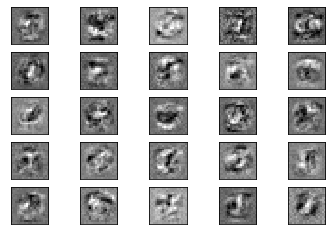

In [19]:
# Visualizing the hidden layer
plt.figure()
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(Theta1[i, 1:].reshape((20, 20)).T,
               cmap=plt.cm.binary, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

We can conclude from this image of the hidden layer that while we don't know what is happening, we can clearly see the darker pixels being centralzied and somehow the numbers are being computed